<a href="https://colab.research.google.com/github/neel0086/deep_learning/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORT DEPENDENCIES**

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
ds = tfds.load('fashion_mnist',split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteFZ4NJG/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteFZ4NJG/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
data_iterator = ds.as_numpy_iterator()
# data_iterator.next()

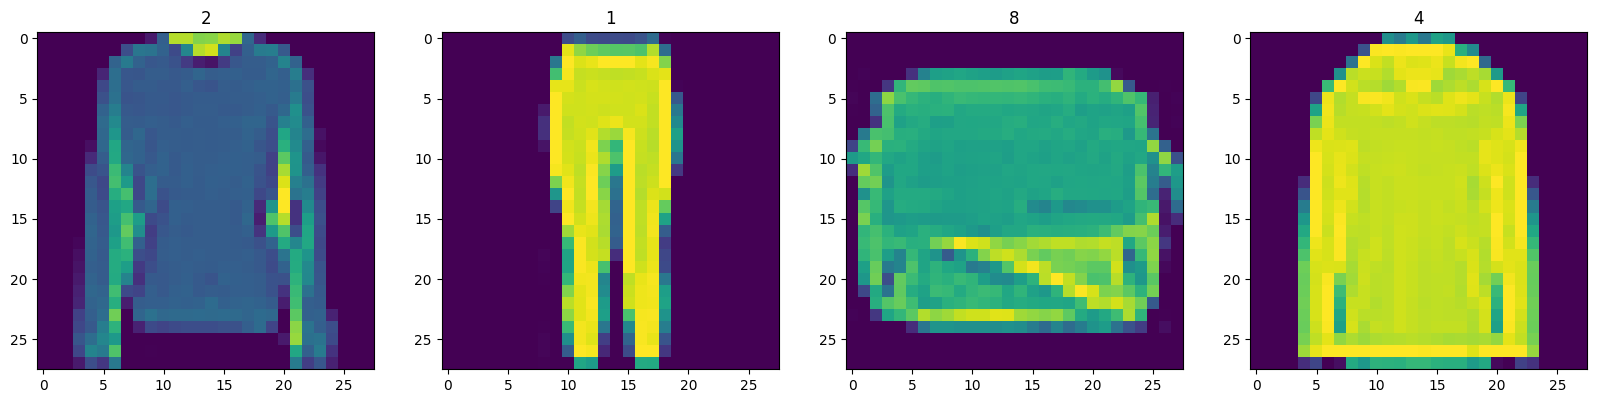

In [4]:
fig,ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
  batch = data_iterator.next()
  ax[idx].imshow(np.squeeze(batch['image']))
  ax[idx].title.set_text(batch['label'])

In [5]:
def scale_images(data):
  image = data['image']
  return image/255

In [6]:
ds = tfds.load('fashion_mnist',split='train')
ds = ds.map(scale_images)
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

In [7]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [8]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
from keras.src.layers.serialization import activation

In [9]:
def build_generator():
  model = keras.Sequential([
      keras.layers.Dense(7*7*128, input_dim=128),
      keras.layers.LeakyReLU(0.2),
      keras.layers.Reshape((7, 7, 128)),

      keras.layers.UpSampling2D(),
      keras.layers.Conv2D(128,5,padding='same'),
      keras.layers.LeakyReLU(0.2),

      keras.layers.UpSampling2D(),
      keras.layers.Conv2D(128,5,padding='same'),
      keras.layers.LeakyReLU(0.2),

      keras.layers.Conv2D(128,4,padding='same'),
      keras.layers.LeakyReLU(0.2),

      keras.layers.Conv2D(128,4,padding='same'),
      keras.layers.LeakyReLU(0.2),

      keras.layers.Conv2D(1,4,padding='same',activation='sigmoid'),



  ])
  return model

In [10]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

1/1 [==============================] - 7s 7s/step


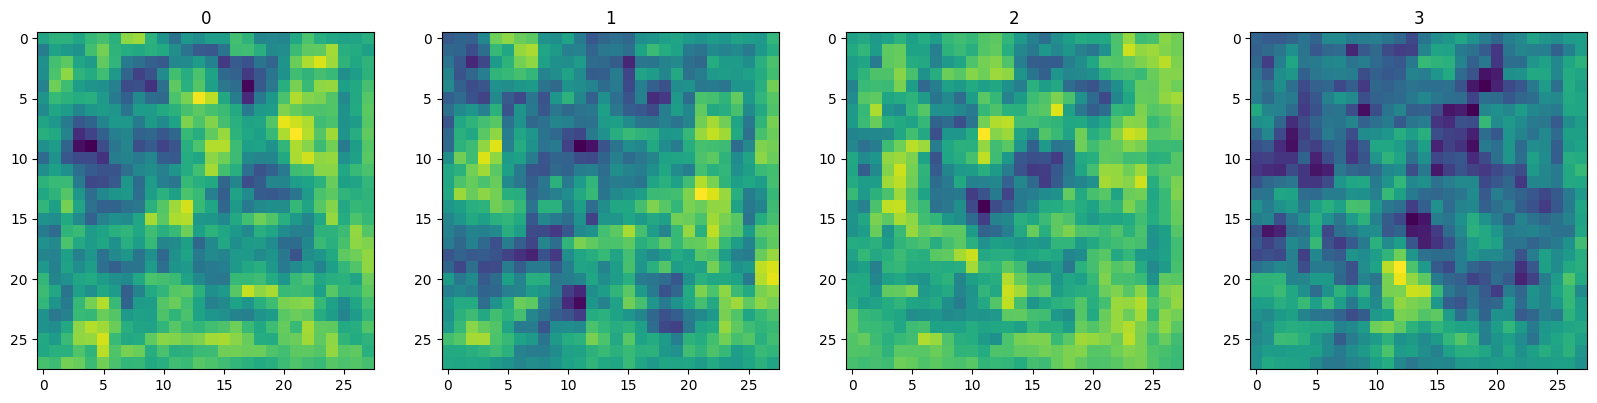

In [11]:
img = generator.predict(np.random.randn(4,128,1))
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(img):
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

In [12]:
img[0].shape

(28, 1)

In [13]:
def build_discriminator():
  model = keras.Sequential([
      keras.layers.Conv2D(32, 5, input_shape = (28,28,1)),
      keras.layers.LeakyReLU(0.2),
      keras.layers.Dropout(0.4),

      keras.layers.Conv2D(64, 5),
      keras.layers.LeakyReLU(0.2),
      keras.layers.Dropout(0.4),

      keras.layers.Conv2D(128, 5),
      keras.layers.LeakyReLU(0.2),
      keras.layers.Dropout(0.4),

      keras.layers.Conv2D(256, 5),
      keras.layers.LeakyReLU(0.2),
      keras.layers.Dropout(0.4),

      keras.layers.Flatten(),
      keras.layers.Dropout(0.4),
      keras.layers.Dense(1, activation='sigmoid'),


  ])
  return model

In [14]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [15]:
img = img[0]


In [16]:
img.shape

(28, 1)

In [17]:
img = np.random.randn(4, 28, 28, 1)
discriminator.predict(img)

1/1 [==============================] - 0s 207ms/step


array([[0.50421673],
       [0.4975956 ],
       [0.5023974 ],
       [0.51765054]], dtype=float32)

# **TRAINING THE MODEL**

In [18]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [19]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [20]:
from tensorflow.keras.models import Model

In [21]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss - BINARYCROSS
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [22]:
fashgan = FashionGAN(generator, discriminator)

In [23]:
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [24]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [27]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

In [28]:
hist = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
  6/469 [..............................] - ETA: 1:12 - d_loss: 0.3174 - g_loss: 5.8103

469/469 [==============================] - 76s 161ms/step - d_loss: 0.3068 - g_loss: 2.4344
Epoch 2/20
469/469 [==============================] - 76s 161ms/step - d_loss: 0.2775 - g_loss: 2.6250
Epoch 3/20
469/469 [==============================] - 76s 161ms/step - d_loss: 0.2749 - g_loss: 2.6867
Epoch 4/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.2733 - g_loss: 2.7438
Epoch 5/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.2726 - g_loss: 2.7711
Epoch 6/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.2719 - g_loss: 2.7893
Epoch 7/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.2702 - g_loss: 2.8034
Epoch 8/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.4798 - g_loss: 1.1515
Epoch 9/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.3329 - g_loss: 0.0705
Epoch 10/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.30

In [1]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()


NameError: ignored